In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import shutil
import torch.distributed as dist
import math
from PIL import Image
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from torch.hub import load_state_dict_from_url
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import BatchSampler
from collections.abc import Mapping, Sequence

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [2]:
train_path_path= f"{os.getcwd()}/data/split_train/train"
test_path_path= f"{os.getcwd()}/data/split_train/val"

In [3]:
batch_size=64
num_gpus=4
num_workers=8
lr=0.001

In [4]:
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                     std=[0.267, 0.256, 0.276])

In [5]:
dataset = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(96),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (9):
    aug_data = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(96),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    dataset=torch.utils.data.ConcatDataset([dataset,aug_data])
valset = datasets.ImageFolder(
        test_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(96),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (9):
    aug_data = datasets.ImageFolder(
        test_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=45),
            
        transforms.RandomResizedCrop(96),
        transforms.ColorJitter(.3,.3,.3,.3),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    valset=torch.utils.data.ConcatDataset([valset,aug_data])

In [6]:
print(len(dataset))
print(len(valset))

40000
10000


In [7]:
train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,
                                 stride=2,padding=3)
        self.act_1 = nn.ReLU()
        self.conv2_bn1 = nn.BatchNorm2d(64)
        self.max_1=nn.MaxPool2d(2,2)
        
        self.layer_2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,
                                 stride=1,padding=2)
        self.act_2 = nn.ReLU()
        self.conv2_bn2 = nn.BatchNorm2d(128)
        self.max_1=nn.MaxPool2d(2,2)
        
        self.layer_3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,
                                 stride=1,padding=2)
        self.act_3 = nn.ReLU()
        self.conv2_bn3 = nn.BatchNorm2d(256)
        self.max_2=nn.MaxPool2d(2,2)
        
        self.layer_4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,
                                 stride=1,padding=2)
        self.act_4 = nn.ReLU()
        self.conv2_bn4 = nn.BatchNorm2d(512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc_layer_1 = nn.Linear(512,10)
        self.act_5 = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
        

    def forward(self, x):
        out = self.layer_1(x)
        out = self.act_1(out)
        for module in list(self.modules())[2:-2]:
            out = module(out)
        out = torch.flatten(out,1)
        for module in list(self.modules())[-2:]:
            out = module(out)
        return out

In [9]:
# for i, data in enumerate(train_loader, 0):
#     inputs, labels = data

In [10]:
# batch_size=1
# model=Model()
# model(inputs[0]).shape

In [11]:
model = Model()
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()

In [12]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

In [13]:
from torchsummary import summary
summary(model,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,472
              ReLU-2           [-1, 64, 48, 48]               0
              ReLU-3           [-1, 64, 48, 48]               0
       BatchNorm2d-4           [-1, 64, 48, 48]             128
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 26, 26]          73,856
              ReLU-7          [-1, 128, 26, 26]               0
       BatchNorm2d-8          [-1, 128, 26, 26]             256
            Conv2d-9          [-1, 256, 28, 28]         295,168
             ReLU-10          [-1, 256, 28, 28]               0
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
             ReLU-14          [-1, 512,

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)

In [15]:
%cd /home/jupyter-deeplearning/res_model

/home/jupyter-deeplearning/res_model


In [16]:
trn_loss_list = []
val_loss_list = []
val_acc_list = []
total_epoch=500
model_char="2.0"
model_name=""
patience=10
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    scheduler.step()
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
    if epoch+1>2:
        if val_loss_list[-1]>val_loss_list[-2]:
            start_early_stop_check=1
    else:
        val_loss_min=val_loss_list[-1]
        
    if start_early_stop_check:
        early_stop_temp=val_loss_list[-patience:]
        if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
            print("Early stop!")
            break
            
    if epoch+1>saving_start_epoch:
        if val_loss_list[-1]<val_loss_min:
            if os.path.isfile(model_name):
                os.remove(model_name)
            val_loss_min=val_loss_list[-1]
            model_name="Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
            torch.save(model, model_name)
            print("Model replaced and saved as ",model_name)

2020/11/10 02:51:01
epoch: 1/500 | trn loss: 1.9320 | val loss: 1.7865 | val accuracy: 35.9375% 

2020/11/10 02:51:16
epoch: 2/500 | trn loss: 1.6777 | val loss: 1.5970 | val accuracy: 41.1659% 

2020/11/10 02:51:31
epoch: 3/500 | trn loss: 1.5128 | val loss: 1.4397 | val accuracy: 48.1170% 

2020/11/10 02:51:46
epoch: 4/500 | trn loss: 1.3933 | val loss: 1.3828 | val accuracy: 50.4908% 

2020/11/10 02:52:01
epoch: 5/500 | trn loss: 1.2906 | val loss: 1.3641 | val accuracy: 51.5024% 

2020/11/10 02:52:17
epoch: 6/500 | trn loss: 1.2100 | val loss: 1.3145 | val accuracy: 52.7344% 

2020/11/10 02:52:32
epoch: 7/500 | trn loss: 1.1347 | val loss: 1.2657 | val accuracy: 55.6290% 

2020/11/10 02:52:47
epoch: 8/500 | trn loss: 1.0783 | val loss: 1.2467 | val accuracy: 55.7692% 

2020/11/10 02:53:03
epoch: 9/500 | trn loss: 1.0193 | val loss: 1.2145 | val accuracy: 57.1915% 

2020/11/10 02:53:18
epoch: 10/500 | trn loss: 0.9741 | val loss: 1.1860 | val accuracy: 58.3934% 

2020/11/10 02:53:34

2020/11/10 03:11:36
epoch: 81/500 | trn loss: 0.4589 | val loss: 1.1189 | val accuracy: 64.0525% 

2020/11/10 03:11:52
epoch: 82/500 | trn loss: 0.4538 | val loss: 1.1312 | val accuracy: 64.6334% 

2020/11/10 03:12:07
epoch: 83/500 | trn loss: 0.4453 | val loss: 1.1400 | val accuracy: 63.2712% 

2020/11/10 03:12:22
epoch: 84/500 | trn loss: 0.4455 | val loss: 1.1265 | val accuracy: 63.9022% 

2020/11/10 03:12:38
epoch: 85/500 | trn loss: 0.4461 | val loss: 1.1067 | val accuracy: 64.2728% 

2020/11/10 03:12:53
epoch: 86/500 | trn loss: 0.4505 | val loss: 1.1261 | val accuracy: 63.9323% 

2020/11/10 03:13:09
epoch: 87/500 | trn loss: 0.4445 | val loss: 1.1145 | val accuracy: 64.0024% 

2020/11/10 03:13:24
epoch: 88/500 | trn loss: 0.4504 | val loss: 1.1212 | val accuracy: 63.5216% 

2020/11/10 03:13:40
epoch: 89/500 | trn loss: 0.4396 | val loss: 1.1140 | val accuracy: 64.1827% 

2020/11/10 03:13:56
epoch: 90/500 | trn loss: 0.4402 | val loss: 1.1205 | val accuracy: 63.8221% 

2020/11/10

2020/11/10 03:39:36
epoch: 159/500 | trn loss: 0.2191 | val loss: 0.9936 | val accuracy: 68.9203% 

2020/11/10 03:40:01
epoch: 160/500 | trn loss: 0.2207 | val loss: 0.9774 | val accuracy: 68.9403% 

2020/11/10 03:40:30
epoch: 161/500 | trn loss: 0.2226 | val loss: 0.9943 | val accuracy: 68.2091% 

2020/11/10 03:40:56
epoch: 162/500 | trn loss: 0.2221 | val loss: 0.9989 | val accuracy: 68.4095% 

2020/11/10 03:41:24
epoch: 163/500 | trn loss: 0.2181 | val loss: 0.9979 | val accuracy: 68.0389% 

2020/11/10 03:41:52
epoch: 164/500 | trn loss: 0.2214 | val loss: 0.9663 | val accuracy: 68.9904% 

2020/11/10 03:42:18
epoch: 165/500 | trn loss: 0.2236 | val loss: 0.9970 | val accuracy: 68.8401% 

2020/11/10 03:42:47
epoch: 166/500 | trn loss: 0.2176 | val loss: 0.9725 | val accuracy: 68.6198% 

2020/11/10 03:43:12
epoch: 167/500 | trn loss: 0.2241 | val loss: 0.9929 | val accuracy: 68.7901% 

2020/11/10 03:43:41
epoch: 168/500 | trn loss: 0.2225 | val loss: 1.0037 | val accuracy: 68.2192% 



2020/11/10 04:23:50
epoch: 239/500 | trn loss: 0.1790 | val loss: 0.9634 | val accuracy: 69.5713% 

2020/11/10 04:24:22
epoch: 240/500 | trn loss: 0.1821 | val loss: 0.9816 | val accuracy: 69.0705% 

2020/11/10 04:25:00
epoch: 241/500 | trn loss: 0.1852 | val loss: 0.9623 | val accuracy: 69.3510% 

2020/11/10 04:25:35
epoch: 242/500 | trn loss: 0.1825 | val loss: 0.9817 | val accuracy: 68.6098% 

2020/11/10 04:26:11
epoch: 243/500 | trn loss: 0.1921 | val loss: 0.9789 | val accuracy: 68.7800% 

2020/11/10 04:26:47
epoch: 244/500 | trn loss: 0.1851 | val loss: 0.9659 | val accuracy: 69.4611% 

2020/11/10 04:27:25
epoch: 245/500 | trn loss: 0.1824 | val loss: 0.9694 | val accuracy: 68.7700% 

2020/11/10 04:28:04
epoch: 246/500 | trn loss: 0.1851 | val loss: 0.9694 | val accuracy: 69.0705% 

2020/11/10 04:28:39
epoch: 247/500 | trn loss: 0.1783 | val loss: 0.9615 | val accuracy: 69.0204% 

2020/11/10 04:29:13
epoch: 248/500 | trn loss: 0.1787 | val loss: 0.9509 | val accuracy: 69.6815% 



2020/11/10 05:12:24
epoch: 320/500 | trn loss: 0.1737 | val loss: 0.9511 | val accuracy: 69.5513% 

2020/11/10 05:12:53
epoch: 321/500 | trn loss: 0.1741 | val loss: 0.9551 | val accuracy: 69.3910% 

2020/11/10 05:13:24
epoch: 322/500 | trn loss: 0.1786 | val loss: 0.9646 | val accuracy: 69.5212% 

2020/11/10 05:13:59
epoch: 323/500 | trn loss: 0.1763 | val loss: 0.9542 | val accuracy: 69.9219% 

2020/11/10 05:14:36
epoch: 324/500 | trn loss: 0.1782 | val loss: 0.9734 | val accuracy: 69.6114% 

2020/11/10 05:15:10
epoch: 325/500 | trn loss: 0.1760 | val loss: 0.9803 | val accuracy: 68.9904% 

2020/11/10 05:15:48
epoch: 326/500 | trn loss: 0.1773 | val loss: 0.9578 | val accuracy: 69.9419% 

2020/11/10 05:16:25
epoch: 327/500 | trn loss: 0.1735 | val loss: 0.9574 | val accuracy: 69.7416% 

2020/11/10 05:17:02
epoch: 328/500 | trn loss: 0.1781 | val loss: 0.9777 | val accuracy: 69.0405% 

2020/11/10 05:17:36
epoch: 329/500 | trn loss: 0.1792 | val loss: 0.9768 | val accuracy: 69.1807% 



2020/11/10 06:01:37
epoch: 402/500 | trn loss: 0.1766 | val loss: 0.9543 | val accuracy: 69.6214% 

2020/11/10 06:02:15
epoch: 403/500 | trn loss: 0.1771 | val loss: 0.9729 | val accuracy: 69.5112% 

2020/11/10 06:02:50
epoch: 404/500 | trn loss: 0.1764 | val loss: 0.9848 | val accuracy: 68.8101% 

2020/11/10 06:03:30
epoch: 405/500 | trn loss: 0.1696 | val loss: 0.9817 | val accuracy: 68.9203% 

2020/11/10 06:04:10
epoch: 406/500 | trn loss: 0.1706 | val loss: 0.9688 | val accuracy: 69.3409% 

2020/11/10 06:04:45
epoch: 407/500 | trn loss: 0.1750 | val loss: 0.9662 | val accuracy: 69.2708% 

2020/11/10 06:05:23
epoch: 408/500 | trn loss: 0.1777 | val loss: 0.9772 | val accuracy: 68.9303% 

2020/11/10 06:05:54
epoch: 409/500 | trn loss: 0.1694 | val loss: 0.9481 | val accuracy: 69.9319% 

2020/11/10 06:06:27
epoch: 410/500 | trn loss: 0.1722 | val loss: 0.9801 | val accuracy: 69.0405% 

2020/11/10 06:06:58
epoch: 411/500 | trn loss: 0.1697 | val loss: 0.9775 | val accuracy: 69.6314% 



2020/11/10 06:50:38
epoch: 484/500 | trn loss: 0.1693 | val loss: 0.9585 | val accuracy: 69.6314% 

2020/11/10 06:51:12
epoch: 485/500 | trn loss: 0.1740 | val loss: 0.9521 | val accuracy: 69.8618% 

2020/11/10 06:51:45
epoch: 486/500 | trn loss: 0.1718 | val loss: 0.9646 | val accuracy: 69.6214% 

2020/11/10 06:52:27
epoch: 487/500 | trn loss: 0.1776 | val loss: 0.9686 | val accuracy: 69.2007% 

2020/11/10 06:53:02
epoch: 488/500 | trn loss: 0.1749 | val loss: 0.9818 | val accuracy: 68.8502% 

2020/11/10 06:53:35
epoch: 489/500 | trn loss: 0.1753 | val loss: 0.9596 | val accuracy: 69.4411% 

2020/11/10 06:54:11
epoch: 490/500 | trn loss: 0.1702 | val loss: 0.9851 | val accuracy: 68.9603% 

2020/11/10 06:54:48
epoch: 491/500 | trn loss: 0.1744 | val loss: 0.9768 | val accuracy: 69.4511% 

2020/11/10 06:55:25
epoch: 492/500 | trn loss: 0.1703 | val loss: 0.9630 | val accuracy: 69.6314% 

2020/11/10 06:56:00
epoch: 493/500 | trn loss: 0.1763 | val loss: 0.9658 | val accuracy: 69.0304% 



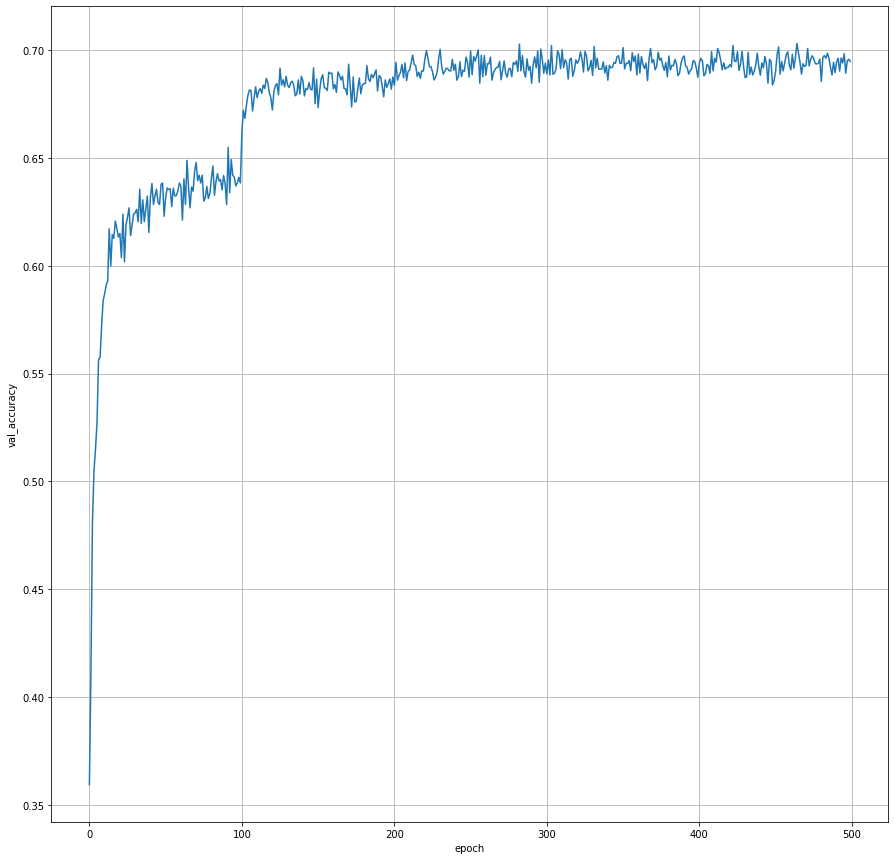

In [17]:
plt.figure(figsize=(15,15))
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.plot(val_acc_list)
plt.grid()

In [18]:
val_acc_list=np.array(val_acc_list)
np.savetxt("ver_2.0.txt", val_acc_list, delimiter=',')

### Evaluation

In [19]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [20]:
model.eval()

Model(
  (layer_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (act_1): ReLU()
  (conv2_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (act_2): ReLU()
  (conv2_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (act_3): ReLU()
  (conv2_bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (act_4): ReLU()
  (conv2_bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1,

In [21]:
%cd /home/jupyter-deeplearning/Organize

/home/jupyter-deeplearning/Organize


In [22]:
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                     std=[0.267, 0.256, 0.276])
test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

In [23]:
test_dataset = torchvision.datasets.ImageFolder('./data/test', transform=test_transform)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

In [25]:
Category = []
for input, _ in test_loader:
    input = input.cuda()
    output = model(input)
    output = torch.argmax(output, dim=1)
    Category = Category + output.tolist()

In [26]:
Id = list(range(0, 8000))
samples = {
   'Id': Id,
   'Category': Category 
}
df = pd.DataFrame(samples, columns=['Id', 'Category'])

df.to_csv('submission_2.0_2.csv', index=False)
print('Done!!')

Done!!
